In [ ]:
# default_exp model.transfer
# default_cls_lvl 2

In [ ]:
#export
from snkrfinder.imports import *
from snkrfinder.core import *
from snkrfinder.data import *
from snkrfinder.model.core import *


In [ ]:
#hide
from nbdev.showdoc import *

# first snkrfinder.model.transfer


# first snkrfinder.model.transfer




## extend model functionality to transfer learning categorization 

This is primarily for validation that distance in our manifold (embedded as features from teh convolutional network) corresponds to "aesthetic similarity".  To the degree that we can distinguish between categories of footwear using that representation.  
I'll also include some simple logistic regression tools which is functionally equivalent to the categorizing "head" layers.


- TRANSFER
    - some generic handlers & classes

- LOGISTIC REGRESSION
    - collculate features and 
    - aggregate into the database

- EXAMPLES I
    - make the FeatureNet
    - load the data
    - calculate the 'features'
d
    

>NOTE:  symbolic link in the nbs directory to enable the module loads in these notebooks.  i.e. `ln -s ../snkrfinder/ snkrfinder`

In [ ]:
#hide
print(fastai.__version__)

2.2.7


Put is in the base snkr-finder directory

In [ ]:
print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkrfinder/nbs
/home/ergonyc/Projects/Project2.0/snkrfinder


In [ ]:
# hide
images_path = D_ROOT/'ut-zap50k-images'

In [ ]:
filename = ZAPPOS_DF_SIMPLIFIED # "zappos-50k-simplified"
df = pd.read_pickle(f"data/{filename}.pkl")

## transfer learning 


### by hand
Here's how we could would do transfer learning "by hand":   

    1. load the pretrained network
    2. create a new linear classifier e.g. `nn.Linear(num_ftrs, n_categories)`
    3. _freeze_ the parameters by setting `param.requires_grad=False` (NOTE, that to actually work we need to NOT freeze batchnorm layers)
    4. create a training loop (or send to a fastai learner)

In [ ]:
#export
def transfer_mobilenet_v2(n_cat=4,freeze=True):
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, n_cat)
    if freeze:
        for param in model_conv.parameters():
            param.requires_grad = False

    return model_conv

### the fastai way
With the fastai API we can simply use `cnn_learner` with the name of the architecture, and everything else is semi-automatic. e.g.
    1. load the arcitecture and trained weights
    3. creating a classifier "head"
    3. setting up the parameters for freezing (avoiding batchnorms)
    
Note that the mobilenet V2 architecture is NOT part of the API so we'll need to get the weights and arch from torchvision, and hack in the the `splitter` and `cut` points.

I'm also going to wrap the dataframe -> DataBlock -> dataloaders in some convenience functions to make the whole shebang just a few lines.

In [ ]:
#export
def get_zappos_datablock(size=IMG_SIZE,rand_aug=True):    
    batch_tfms = Normalize.from_stats(*imagenet_stats)
    if rand_aug:
        rand_tfms = aug_transforms(mult=1.0, 
                   do_flip=True, 
                   flip_vert=False, 
                   max_rotate=3.0, 
                   min_zoom=.95, 
                   max_zoom=1.0, 
                   max_lighting=0.1, 
                   max_warp=0.023, 
                   p_affine=0.66, 
                   p_lighting=0.2, 
                   xtra_tfms=None, 
                   size=None, 
                   mode='bilinear', 
                   pad_mode='border', 
                   align_corners=True, 
                   batch=False, 
                   min_scale=1.0)
        batch_tfms = rand_tfms+[batch_tfms]
                      
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=ColSplitter('is_valid'), 
                   get_x=zap_get_x, 
                   get_y=zap_get_y,
                   item_tfms=Resize(size, method='pad', pad_mode='border'),
                   batch_tfms=batch_tfms)  # border pads white...
    return dblock

In [ ]:
#export
def prep_df_for_datablocks(df):
    df = df[["Category","path","train","test","validate","t_t_v"]].copy()
    # I could remove all the "test" rows... for now i'll choose an alternate strategy:
    # Drop all the "test" rows for now, and create an "is_valid" column...
    # should probably drop a ton of columns to jus tkeep the file paths...
    # just keep what we'll need below
    df.loc[:,'is_valid'] = df.test | df.validate
    return df


def get_zappos_cat_dataloaders(data=None,batch_size=32, size=IMG_SIZE, device=None):
    # put everythign in train, and don't do any augmentation since we are just going 
    # resize to 224
    # set up the helper functions to pass data into the
    if device is None:
        device = get_cuda()
    if data is None:
        filename = ZAPPOS_DF_SIMPLIFIED # "zappos-50k-simplified"
        data = pd.read_pickle(f"data/{filename}.pkl")
    
    data = prep_df_for_datablocks(data)

    dblock = get_zappos_datablock(size=size)
        
    dls = dblock.dataloaders(data,bs=batch_size,drop_last=True,device=device)
    return dls

In [ ]:
filename = ZAPPOS_DF_SIMPLIFIED # "zappos-50k-simplified"
df = pd.read_pickle(f"data/{filename}.pkl")
df = prep_df_for_datablocks(df)

In [ ]:
df.shape[0]/32

862.9375

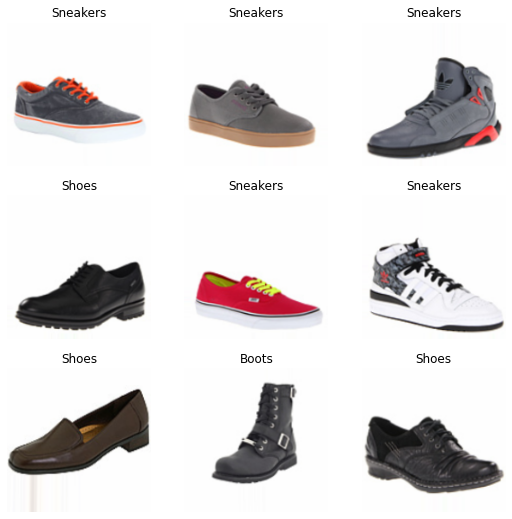

In [ ]:
#df = df.sample(df.shape[0]-1)
#dls = get_zappos_cat_dataloaders(df)
dls = get_zappos_cat_dataloaders()
rnet_learn = cnn_learner(dls, resnet18, metrics=error_rate)
dls.show_batch()

(0.010000000149011612,
 0.0012022644514217973,
 0.005601132300216705,
 0.003467369358986616)

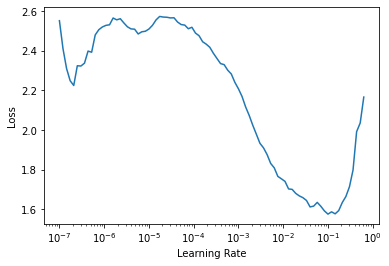

In [ ]:
lr_min,lr_steep = rnet_learn.lr_find()
mlr = .5*(lr_min+lr_steep)
#geometric mean
gmlr = torch.tensor([lr_min,lr_steep]).log().mean().exp().tolist()
lr_min,lr_steep,mlr,gmlr

epoch,train_loss,valid_loss,error_rate,time
0,0.418728,0.311163,0.109354,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.242785,0.193364,0.064937,00:33
1,0.164135,0.150097,0.052625,00:33


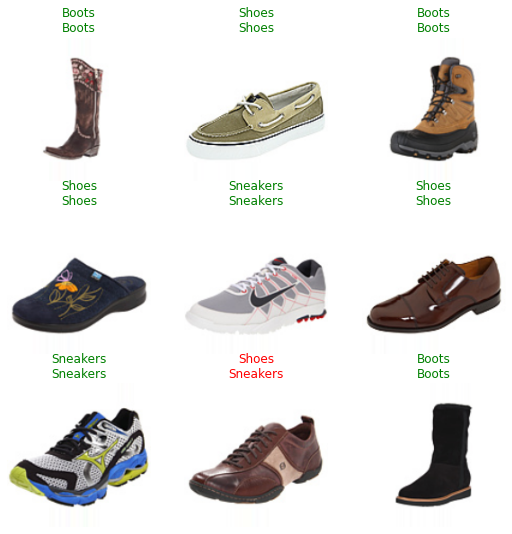

In [ ]:
rnet_learn.fine_tune(2, base_lr=gmlr,freeze_epochs=1)
rnet_learn.show_results()

In [ ]:

filename = 'rnet18_transfer-feb20_1x2b'
rnet_learn.save(filename)

Path('models/rnet18_transfer-feb20_1x2b.pth')

In [ ]:
rnet_learn.export(fname=filename)

epoch,train_loss,valid_loss,error_rate,time
0,0.128995,0.150681,0.053470,00:28
1,0.129255,0.150410,0.053712,00:28
2,0.126794,0.151045,0.052505,00:28
3,0.124559,0.154899,0.053591,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.139179,0.150539,0.052142,00:33
1,0.139488,0.149569,0.052505,00:33


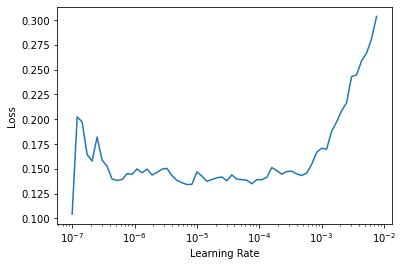

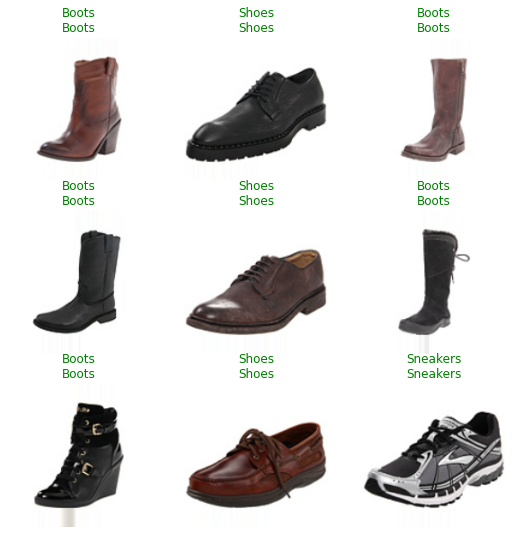

In [ ]:
freeze_epochs,epochs = 4,2
lr_min,lr_steep = rnet_learn.lr_find()
#geometric mean
gmlr = torch.tensor([lr_min,lr_steep]).log().mean().exp().tolist()

rnet_learn.fine_tune(epochs, base_lr=gmlr,freeze_epochs=freeze_epochs)
rnet_learn.show_results()

In [ ]:
filename = f'rnet18_transfer-feb20_{freeze_epochs}x{epochs}b'
rnet_learn.save(filename)

rnet_learn.save('rnet18_transfer-fep20_1x2')
rnet_learn.export(fname=filename)

In [ ]:
def cnn_learner(dls, arch, normalize=True, n_out=None, pretrained=True, config=None,
                # learner args
                loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                # other model args
                **kwargs):
    "Build a convnet style learner from `dls` and `arch`"

    meta = model_meta.get(arch, _default_meta)

    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    model = create_cnn_model(arch, n_out, pretrained=pretrained, **kwargs)

    splitter=ifnone(splitter, meta['split'])
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn


In [ ]:
mnet_learn = cnn_learner(dls,torchvision.models.mobilenet_v2, n_out=4,
                    pretrained=True,metrics=error_rate)

NameError: name '_default_meta' is not defined

In [ ]:
lr_min,lr_steep = mnet_learn.lr_find()
mlr = .5*(lr_min+lr_steep)
#geometric mean
gmlr = torch.tensor([lr_min,lr_steep]).log().mean().exp().tolist()
lr_min,lr_steep,mlr,gmlr

NameError: name 'mnet_learn' is not defined

In [ ]:
freeze_epochs,epochs = 4,2
mnet_learn.fine_tune(epochs, base_lr=gmlr,freeze_epochs=freeze_epochs)
mnet_learn.show_results()

NameError: name 'mnet_learn' is not defined

In [ ]:
filename = f'mnet18_transfer-feb20_{freeze_epochs}x{epochs}b'
rnet_learn.save(filename)
rnet_learn.export(fname=filename)

In [ ]:
freeze_epochs,epochs = 2,1
mnet_learn = cnn_learner(dls,torchvision.models.mobilenet_v2, n_out=4,
                    pretrained=True,metrics=error_rate)

lr_min,lr_steep = mnet_learn.lr_find()
gmlr = torch.tensor([lr_min,lr_steep]).log().mean().exp().tolist() #geometric mean

mnet_learn.fine_tune(epochs, base_lr=gmlr,freeze_epochs=freeze_epochs)
mnet_learn.show_results()

NameError: name '_default_meta' is not defined

In [ ]:
filename = f'mnet18_transfer-feb20_{freeze_epochs}x{epochs}b'
rnet_learn.save(filename)
rnet_learn.export(fname=filename)

In [ ]:
interp = Interpretation.from_learner(mnet_learn)
interp.plot_top_losses(9, figsize=(15,10))

NameError: name 'mnet_learn' is not defined

In [ ]:
rnet_learn=load_learner('rnet_transfer-feb20_1x2a')

FileNotFoundError: [Errno 2] No such file or directory: 'rnet_transfer-feb20_1x2a'

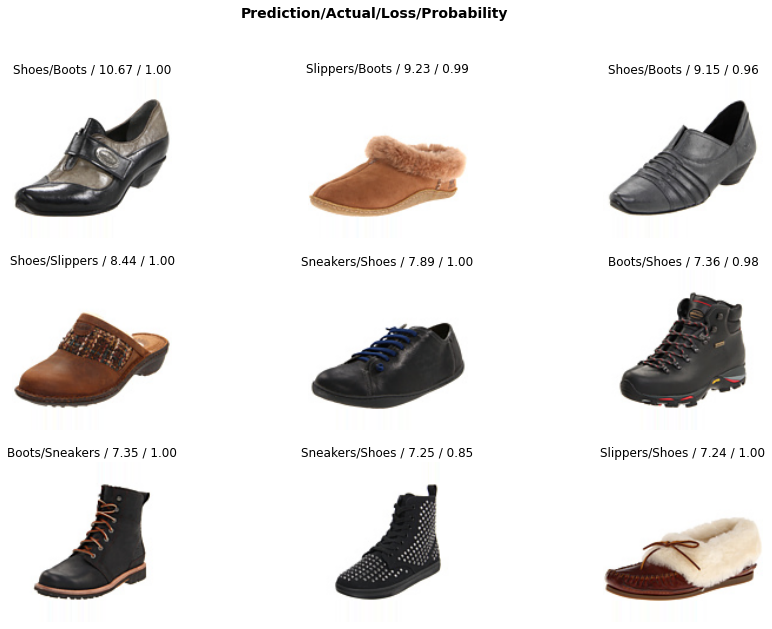

In [ ]:
interp = Interpretation.from_learner(rnet_learn)
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
interp.plot_top_losses()


## export

In [ ]:
from nbdev.export import notebook2script
notebook2script()

